# Selección Automática de Modelos

A lo largo de este notebook se explorará la fucnionalidad de selección automática de modelos mediante *AutoML*.

## Configuración Inicial

Importación de librerias y comprobaciones iniciales aqui:

In [1]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging
from sklearn import datasets
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random
import numpy as np

## Conexion al Workspace

Nos conectamos al workspace de Azure Machine Learning:

In [2]:
ws = Workspace.from_config()
project_folder = './automl-local-classification'
experiment_name = 'automl-mnist'

import os

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

Found the config file in: c:\Sources\SQLSatMadrid2018\06-AutoML via Notebook\config.json


,
SDK version,0.1.68
Subscription ID,d77fed05-748d-4c3c-97af-00e6cdd6c46e
Workspace,SQLSat2018Workspace
Resource Group,SQLSatMadrid
Location,eastus
Project Directory,./automl-local-classification


## Estudio de los Datos

Vamos a cargar los digitos del MNIST, dejando las 100 primeras filas para le test:

In [5]:
from sklearn import datasets

digits = datasets.load_digits()

X_train = digits.data[100:,:]
y_train = digits.target[100:]

Ahora mostramos algunas de estas imagenes, para hacernos mejor a la idea del contenido:

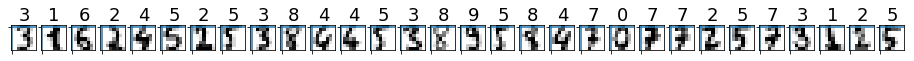

In [6]:
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 2, y = -2, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(8, 8), cmap = plt.cm.Greys)
plt.show()

## Creación del Modelo

Vamos a emplear AutoML para la eleccion automatizada del modelo:

In [7]:
from azureml.train.automl import AutoMLConfig

Automl_config = AutoMLConfig(task = 'classification',
                             primary_metric = 'AUC_weighted',
                             max_time_sec = 12000,
                             iterations = 20,
                             n_cross_validations = 3,
                             preprocess = False,
                             exit_score = 0.9985,
                             blacklist_algos = ['kNN','LinearSVM'],
                             X = X_train,
                             y = y_train,
                             path=project_folder)

Ahora lo ejecutamos:

In [8]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Parent Run ID: AutoML_c0c1bc20-fb7e-4e2a-984f-aff4fc3e34b4
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      MaxAbsScaler SGDClassifierWrapper     0:00:44.599406           0.994     0.994
         1      RobustScaler NBWrapper                0:00:43.746301           0.992     0.994
         2      RobustScaler KNeighborsClassifier     0:00:41.799219           0.999     0.999
Stopping criteria reached at iteration 3. Ending experiment.

## Exploración de los Resultados

Vamos a usar el widget de Jupyter para ver los resultados de la ejecución:


In [10]:
from azureml.train.widgets import RunDetails
RunDetails(local_run).show()

_AutoML(widget_settings={'childWidgetDisplay': 'popup'})

También podemos obtener programaticamente todas las ejecuciones:

In [11]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2
AUC_macro,0.993649,0.991635,0.999369
AUC_micro,0.974963,0.992614,0.999472
AUC_weighted,0.993672,0.991555,0.999378
AUC_weighted_max,0.993672,0.993672,0.999378
accuracy,0.793793,0.900423,0.979377
average_precision_score_macro,0.956203,0.944573,0.996192
average_precision_score_micro,0.844175,0.947317,0.996926
average_precision_score_weighted,0.956788,0.944635,0.996167
balanced_accuracy,0.881860,0.944746,0.988598
f1_score_macro,0.790292,0.901021,0.979316


## Guardando el Mejor Modelo

In [13]:
# find the run with the highest accuracy value.
best_run, fitted_model = local_run.get_output()

# register model in workspace
description = 'Automated Machine Learning Model for MNIST'
tags = None
local_run.register_model(description=description, tags=tags)
local_run.model_id 

Registering model AutoMLc0c1bc20fbest


'AutoMLc0c1bc20fbest'